In [ ]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from shapely import force_2d
from shapely.geometry import box, Point, Polygon, MultiPolygon
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from pykrige.rk import Krige
from pykrige.ok import OrdinaryKriging
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

from flood_density.plots import plot_gdf, city_bounds_and_density_plot
from flood_density.preprocess import convert_kml_to_gdf, export_to_geojson, get_bounds_xy_min_max, extract_bounds_polygon, polygon_to_gdf, extract_city_data, coordinates_to_box,points_geocoordinates,convert_points_in_gdf, extract_city_bounds_from_df_to_gdf , gdf_to_geojson, clip_density_to_urban_area, prepare_coords 

from typing import List, Tuple, Callable

CRS_4326 = 4326


# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

In [2]:
gdf_from_kml = convert_kml_to_gdf('laplata_cascourbano.kml')


/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
gdf_peligrosidad = export_to_geojson(gdf_from_kml, 'laplata_cascourbano.geojson')

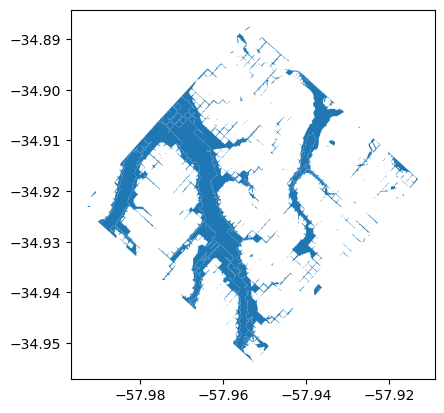

In [4]:
plot_peligrosidad = plot_gdf(gdf_peligrosidad)

# Etapa 2: Obtener las coordenadas de los puntos de la ciudad, formamos un polígono y luego, transformamos a un gdf.


In [5]:
#¿Cómo obtengo bounds_dict? son coordenadas de la ciudad de La Plata Desde el archivo geojson

In [6]:
#Extraemos las coordenadas geográficas de la ciudad 
city_bounds_coordinates= get_bounds_xy_min_max(gdf_peligrosidad)
city_bounds_coordinates

{'x_min': -57.992667,
 'y_min': -34.953843,
 'x_max': -57.91312,
 'y_max': -34.887489}

In [7]:
# Convertimos las coordenadas de la ciudad a un box
boxx = coordinates_to_box(city_bounds_coordinates)

In [8]:
#Usar el dataframe del polígono que forma las coordenadas de la LP
gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')

In [9]:
# Convertir a EPSG 32721 (UTM zona 21S)
gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=32721)

# Etapa 3 : Obtener y transformar datos de densidad poblacional de la ciudad de La Plata.

Primero extraemos las filas que pertenecen a la ciudad de La Plata(sigue siendo un .csv), luego convertimos ese dataframe en un geodataframe.

In [10]:
#Levantamos el dataset completo
df_arg = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv") 

In [11]:
# Extraemos las filas referidas a la ciudad de La Plata
df_lp_coordinates = extract_city_data(df_arg,'la_plata',city_bounds_coordinates)
df_lp_coordinates

,X,Y,Z
2005769,-57.988750,-34.887916,4390.450195
2005770,-57.980416,-34.887916,4219.690918
2005771,-57.972083,-34.887916,3577.566895
2005772,-57.963750,-34.887916,4450.521973
2005773,-57.955416,-34.887916,3841.554199
...,...,...,...
2016355,-57.947083,-34.946250,4543.715820
2016356,-57.938750,-34.946250,4086.931885
2016357,-57.930416,-34.946250,3947.445801
2016358,-57.922083,-34.946250,3537.828613


In [12]:
#Leemos los datos específicos de la ciudad de La Plata
df_lp_coordinates = pd.read_csv('la_plata_population_2020.csv')
df_lp_coordinates


,X,Y,Z
0,-57.988750,-34.887916,4390.450195
1,-57.980416,-34.887916,4219.690918
2,-57.972083,-34.887916,3577.566895
3,-57.963750,-34.887916,4450.521973
4,-57.955416,-34.887916,3841.554199
...,...,...,...
75,-57.947083,-34.946250,4543.715820
76,-57.938750,-34.946250,4086.931885
77,-57.930416,-34.946250,3947.445801
78,-57.922083,-34.946250,3537.828613


In [13]:
#Convertir dataframe de los puntos pertenecientes a la ciudad de La Plata en un geodataframe
gdf_lp_coordinates = extract_city_bounds_from_df_to_gdf(df_lp_coordinates, 'Y','X')

In [14]:
# Extraemos las coordenadas de los puntos dentro de la ciudad de La Plata
casco_urbano = clip_density_to_urban_area(gdf_lp_coordinates,gdf_peligrosidad)

In [15]:
# Reproyectar a EPSG 32721 (UTM zona 21S)
casco_urbano_utm = casco_urbano.to_crs(epsg=32721)
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


In [16]:
# Calcular centroides en el CRS proyectado
centroides = casco_urbano_utm.geometry.centroid

In [17]:
# Convertir centroides a un array de coordenadas
coords_centroides = np.array([[pt.x, pt.y] for pt in centroides])

In [18]:
# Extraer densidades de casco_urbano_utm
values_density_lp = casco_urbano_utm['Z'].values

In [19]:
#Extraer los límites del polígono de la ciudad de La Plata
bounds_lp = gdf_la_plata_from_polygon.total_bounds  # [minx, miny, maxx, maxy]
bounds_lp

array([ 409292.09738085, 6131625.70628701,  416628.30365384,
       6139053.5533489 ])

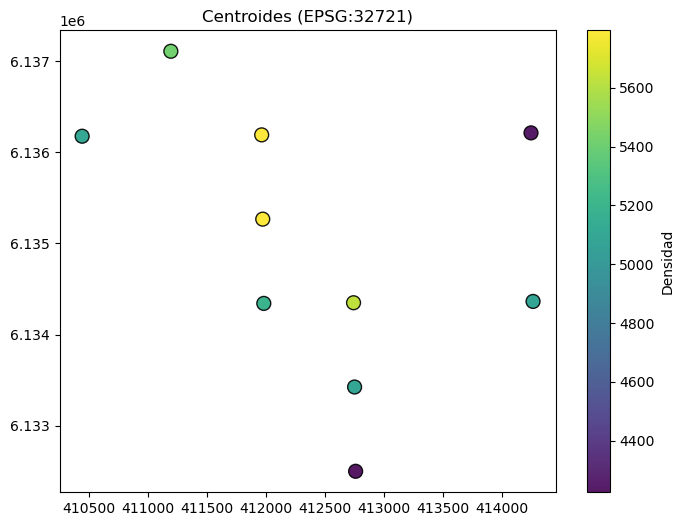

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(coords_centroides[:, 0], coords_centroides[:, 1],
                c=values_density_lp, s=100,
                cmap='viridis', alpha=0.9,
                edgecolor='black', linewidth=1,
                marker='o')

plt.colorbar(sc, ax=ax, label='Densidad')
ax.set_title("Centroides (EPSG:32721)")
plt.show()

# Etapa 4 : Merge polígono y zona de densidad de la ciudad de La Plata en un plot para corroborar consistencia geográfica.

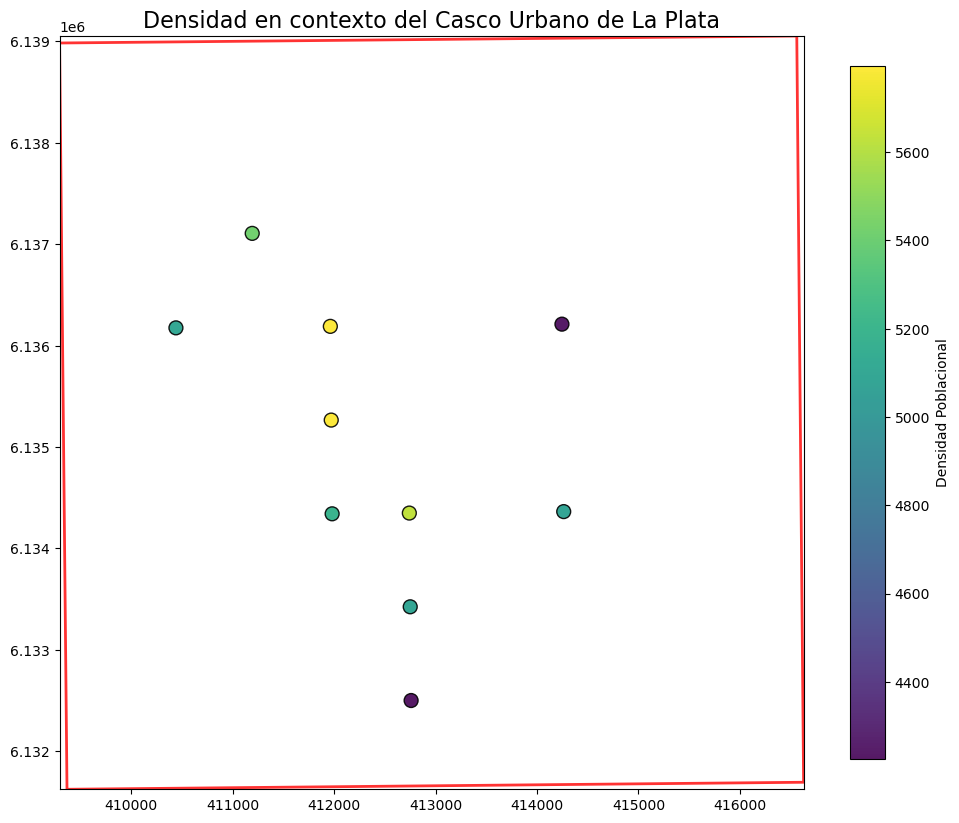

In [21]:
city_bounds_and_density_plot(gdf_la_plata_from_polygon, coords_centroides, values_density_lp, bounds_lp)

# Etapa 5 :  Visualización de la densidad poblacional de La Plata usando kriging.

In [22]:
casco_urbano_utm

,X,Y,Z,geometry,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (411191.477 6137107.129),La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (410439.177 6136175.537),La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (411961.724 6136190.323),La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (414245.539 6136212.026),La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (411970.623 6135266.155),La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (411979.523 6134341.986),La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (412740.641 6134349.285),La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (414262.876 6134363.694),La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (412749.467 6133425.116),La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (412758.294 6132500.945),La Plata,descripción: <br>name: La Plata <br>descriptio...


## 1. Preparar los datos (coordenadas y centroides)

In [57]:
prepare_coords(casco_urbano_utm, 'Z')

Rango de valores: 4224.70 - 5795.11


array([5416.42822266, 5103.67285156, 5795.11035156, 4231.40966797,
       5794.33007812, 5190.81787109, 5635.42675781, 5082.84863281,
       5090.87841797, 4224.69726562])

In [58]:
def prepare_centroids(gdf: gpd.GeoDataFrame) -> np.ndarray:

    # Extraer centroides y convertir a un array de coordenadas
    centroids = np.array([[point.x, point.y] for point in gdf.geometry.centroid])
    
    return centroids

In [59]:
prepare_centroids(casco_urbano_utm)

array([[ 411191.47705537, 6137107.12919731],
       [ 410439.17718122, 6136175.53731404],
       [ 411961.72382994, 6136190.32296704],
       [ 414245.53895849, 6136212.02599051],
       [ 411970.62252151, 6135266.15516394],
       [ 411979.52307898, 6134341.98612686],
       [ 412740.64147876, 6134349.28542649],
       [ 414262.87636074, 6134363.69380399],
       [ 412749.4669027 , 6133425.11593676],
       [ 412758.29417604, 6132500.94521217]])

In [ ]:
#def create_kriging_kernel(constant_value=1.0, length_scale=1000.0, noise_level=0.1,
#                         length_scale_bounds=(1e-5, 1e5), noise_level_bounds=(1e-10, 1e3)):
#    """
#    Crea un kernel para un modelo de Kriging (Gaussian Process).
#    
#    El kernel resultante tiene la forma: C * RBF + WhiteKernel
#    donde C es una constante, RBF es el kernel de función de base radial,
#    y WhiteKernel modela el ruido en las observaciones.
#    
#    Parámetros:
#    -----------
#    constant_value : float, default=1.0
#        Valor inicial del ConstantKernel (amplitud del proceso)
#    length_scale : float, default=1000.0
#        Valor inicial del RBF kernel (escala de correlación espacial)
#    noise_level : float, default=0.1
#        Valor inicial del WhiteKernel (nivel de ruido)
#    length_scale_bounds : tuple, default=(1e-5, 1e5)
#        Límites para optimización del parámetro length_scale del RBF
#    noise_level_bounds : tuple, default=(1e-10, 1e3)
#        Límites para optimización del parámetro noise_level del WhiteKernel
#    
#    Returns:
#    --------
#    kernel : sklearn.gaussian_process.kernels.Kernel
#        Objeto kernel listo para usar en GaussianProcessRegressor
#        
#    Ejemplo:
#    --------
#    >>> from sklearn.gaussian_process import GaussianProcessRegressor
#    >>> kernel = create_kriging_kernel(length_scale=500.0, noise_level=0.05)
#    >>> gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)
#    """
#    # Kernel constante (amplitud)
#    constant_kernel = ConstantKernel(constant_value, constant_value_bounds="fixed")
#    
#    # Kernel RBF (correlación espacial)
#    rbf_kernel = RBF(length_scale=length_scale, length_scale_bounds=length_scale_bounds)
#    
#    # Kernel de ruido
#    noise_kernel = WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)
#    
#    # Combinar kernels: (Constante * RBF) + Ruido
#    kernel = constant_kernel * rbf_kernel + noise_kernel
#    
#    return kernel

In [ ]:
#kernel = create_kriging_kernel()


In [27]:
#model_fit_kriging = fit_kriging(coords_centroides, values_density_lp)

In [34]:
#def plot_kriging_results_with_basemap(gdf: gpd.GeoDataFrame, 
#                                      coords: np.ndarray, 
#                                      bounds: Tuple[float, float, float, float], 
#                                      grid_x: np.ndarray, 
#                                      grid_y: np.ndarray, 
#                                      model: OrdinaryKriging, 
#                                      predict_fn: Callable[[OrdinaryKriging, np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]) -> plt.Figure:
#
#    fig, ax = plt.subplots(figsize=(10, 10))
#
#    # Obtener la superficie interpolada desde la función predict_fn
#    grid_z, ss = predict_fn(model, grid_x, grid_y)
#    
#    # Plotear superficie Kriging interpolada
#    contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.5)
#    
#
#    # Plotear los polígonos originales
#    casco_urbano_utm.plot(column='Z', 
#               cmap='viridis',
#               alpha=0.5,
#               edgecolor='black',
#               linewidth=1.0,
#               ax=ax)
#
#    # Plotear los polígonos originales con bordes
#    casco_urbano_utm.plot(column='Z', 
#               cmap='viridis',
#               alpha=0.5,
#               edgecolor='black',
#               linewidth=1.0,
#               ax=ax)
#
#    # Plotear los puntos centroides
#    scatter = ax.scatter(coords[:, 0], coords[:, 1],
#                    c=gdf['Z'],
#                    cmap='viridis',
#                    s=30,
#                    edgecolors='black',
#                    linewidths=1,
#                    zorder=5)
#
#    # Ajustar límites del gráfico según los límites de La Plata
#    ax.set_xlim(bounds[0], bounds[2])
#    ax.set_ylim(bounds[1], bounds[3])
#
#    #Mapa base más sutil
#    ctx.add_basemap(ax, crs=casco_urbano_utm.crs.to_string(),
#                   source=ctx.providers.CartoDB.Positron,
#                   alpha = 0.9)
#
#    # Agregar colorbar para el scatter
#    plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)
#
#    # Agregar título y etiquetas
#    ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
#    ax.set_xlabel('X (UTM)')
#    ax.set_ylabel('Y (UTM)')
#
#    plt.tight_layout()
#    plt.show()
#

In [35]:
#plot_kriging_results_with_basemap(casco_urbano_utm, coords_centroides, bounds_lp, grid_x, grid_y, model_fit_kriging, predict_grid)

In [36]:
# 5. Pipeline principal
#def run_kriging_pipeline(geodf, value_column, bounds, step=100):
#    coords, values = prepare_data(geodf, value_column)
#    model = fit_kriging(coords, values)
#    grid_xx, grid_yy, z = interpolate_grid(model, bounds, step)
#    plot_kriging_results(grid_xx, grid_yy, z, coords, values, bounds)

---------------------------------

In [40]:
# 3. Generar el modelo GaussianProcessRegressor
def gaussian_process_regressor(kernel: kernel, coords: np.ndarray, values: np.ndarray) -> GaussianProcessRegressor:
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10)
    gpr.fit(coords, values)
    return gpr

In [41]:
model_gpr = gaussian_process_regressor(kernel, coords_centroides, values_density_lp)

/home/andy/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/andy/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [42]:
type(model_gpr)

sklearn.gaussian_process._gpr.GaussianProcessRegressor

In [43]:
# 4. Crear malla para interpolar

def interpolate_grid(
    bounds: Tuple[float, float, float, float],
    step: int = 100
) -> Tuple[np.ndarray, np.ndarray]:

    # Crear malla con np.mgrid
    grid_x, grid_y = np.mgrid[bounds[0]:bounds[2]:step*1j, bounds[1]:bounds[3]:step*1j]

    # Crear coordenadas de la malla
    grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    return grid_x, grid_y, grid_coords

In [ ]:
grid_x, grid_y, grid_coords = interpolate_grid(bounds_lp, step=100)
interpolate_lp = interpolate_grid(bounds_lp, step=100)


In [ ]:
# 5. Predecir en la malla

def predict_grid(
    model: GaussianProcessRegressor, 
    grid: Tuple[np.ndarray, np.ndarray, np.ndarray]
) -> Tuple[np.ndarray, np.ndarray]:
    
    # Desempaquetar la tupla grid
    grid_x, grid_y, _ = grid

    # Preparar puntos para predicción
    points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    
    # Predecir
    z, ss = model.predict(points, return_std=True)

    return z, ss


In [47]:
predict_grid_lp = predict_grid(model_gpr, interpolate_lp)

In [49]:
type(predict_grid_lp)

tuple

In [ ]:
# 6. Convertir resultados a grillas 2D

def convert_to_2d_grid(
    data: Tuple[np.ndarray, np.ndarray], 
    grid_shape: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:

    # Desempaquetar la tupla data
    z, ss = data 

    # Convertir a grillas 2D los valores predichos
    z_2d = z.reshape(grid_shape)

    # Convertir a grillas 2D las desviacciones estándar(incertidumbre)
    ss_2d = ss.reshape(grid_shape)

    return z_2d, ss_2d


In [ ]:
predict_grid_lp = predict_grid(model_gpr, (grid_x, grid_y, grid_coords))
grid_2d_lp = convert_to_2d_grid(predict_grid_lp, grid_x.shape)

In [ ]:
predict_grid(model_gpr, grid_x, grid_y)

In [ ]:
# Visualización de la densidad poblacional de La Plata usando kriging

# Extraer coordenadas y valores desde el GeoDataFrame
#coords =np.array([[point.x, point.y] for point in casco_utm.geometry.centroid])
#values = casco_urbano['densidad_poblacional_lp'].values
#
#print(f"Puntos de datos: {len(coords)}")
#print(f"Rango de valores: {values.min():.2f} - {values.max():.2f}")
#
##Definir kernel para el modelo de kriging
#kernel = (ConstantKernel(1.0) * RBF(length_scale=1000.0) + 
#          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e3)))
#
## Crear modelo de kriging
#gpr = GaussianProcessRegressor(kernel=kernel,
#                                n_restarts_optimizer=10,
#                                alpha=1e-04,
#                                normalize_y=True)
#
## Crear grid de puntos para interpolación
#bounds_casco_lp = casco_utm.total_bounds
#grid_x, grid_y = np.mgrid[bounds_casco_lp[0]:bounds_casco_lp[2]:100j, bounds_casco_lp[1]:bounds_casco_lp[3]:100j]
#grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])
#
#
#
## Entrenar el modelo
#gpr.fit(coords, values)
#
##Predecir en el grid
#grid_2_kriging, pred_std = gpr.predict(grid_coords, return_std=True)
#grid_z = grid_2_kriging.reshape(grid_x.shape)
#grid_uncertainty = pred_std.reshape(grid_x.shape)
#
## Visualización de la superficie Kriging interpolada
#fig, ax = plt.subplots(figsize=(8, 10))
#
## Plotear superficie Kriging interpolada
#contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.7)
#
## Plotear los polígonos originales con bordes
#casco_utm.plot(column='densidad_poblacional_lp', 
#               cmap='viridis',
#               alpha=0.5,
#               edgecolor='black',
#               linewidth=1.0,
#               ax=ax)
#
## Plotear los puntos centroides
#scatter = ax.scatter(coords[:, 0], coords[:, 1],
#                    c=values,
#                    cmap='viridis',
#                    s=30,
#                    edgecolors='black',
#                    linewidths=1,
#                    zorder=5)
#
##Mapa base más sutil
#ctx.add_basemap(ax, crs=casco_utm.crs.to_string(),
#               source=ctx.providers.CartoDB.Positron,
#               alpha = 0.9)
#
## Agregar colorbar para el scatter
#plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)
#
## Agregar título y etiquetas
#ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
#ax.set_xlabel('X (UTM)')
#ax.set_ylabel('Y (UTM)')
#
#plt.tight_layout()
#plt.show()
#

In [ ]:
def export_to_geotiff(grid_data: np.ndarray, gdf: gpd.GeoDataFrame,  crs_epsg: int = 32721):

     # Crear un GeoDataFrame con los límites del área de La Plata en EPSG:4326
    boxx = coordinates_to_box(city_bounds_coordinates) 
    gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')
    
    # Transformar al CRS del plot
    gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=32721)

    # Obtener límites en coordenadas proyectadas
    bounds_proj = gdf_la_plata_from_polygon.total_bounds  # [xmin, ymin, xmax, ymax]
    height, width = grid_data.shape

    # Calcula la transformación georreferenciada
    transform = from_bounds(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3], width, height)

    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=grid_data.dtype,
        crs=CRS.from_epsg(crs_epsg),
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(grid_data, 1)
        dst.set_band_description(1, 'Densidad Poblacional Kriging')



In [ ]:
# Exportar superficie interpolada
export_to_geotiff(grid_z, gdf_la_plata_from_polygon, 32721)

# Etapa 5 : superposición de mapas de densidad y peligrosidad de inundación de la ciudad de La Plata (QGIS).